---
# Query Analysis Layer
---

In [2]:
from dotenv import load_dotenv

from typing import Annotated, Literal
from typing_extensions import TypedDict

from IPython.display import Image, display

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from functools import partial

from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field

## Load Environment Variables

In [3]:
load_dotenv(override=True)

True

## The Graph

In the **query analysis layer**, we want to build:
* Query Decomposition
* Query Expansion
* Hypothetical Document Embeddings (HyDE)
* Query Routing

#### State Definition

In [4]:
class State(TypedDict):
    query: str
    decomposed_queries: list[str]
    expanded_queries: list[str]
    hyde_queries: str
    step_back_prompting_queries: list[str]
    messages: list[str]

class ModelInput(TypedDict):
    query: str

class DecomposedModelOutput(TypedDict):
    decomposed_model: list[str]

class ExpandedModelOutput(TypedDict):
    expanded_model: list[str]

class HyDEModelOutput(TypedDict):
    hyde_model: str

class StepBackPromptingModelOutput(TypedDict):
    step_back_prompting_model: str

class CombinedModelInput(TypedDict):
    decomposed_queries: list[str]
    expanded_queries: list[str]
    hyde_queries: str
    step_back_prompting_queries: list[str]

class CombinedModelOutput(TypedDict):
    messages: list[str]

#### The Prompts

In [5]:
decomposition_system = """Perform query decomposition. Given a user question break it down into distinct sub questions that you need to answer in order to answer the original question. User question: {query}
"""

expansion_system = """Perform query expansion. If there are multiple ways of phrasing a user question or common synonyms for the key words in the question, make sure to return multiple versions of the query with different phrasings. Always encapsulate the entire original query in the expanded queries. If there are words you are not familiar with, do not try to rephrase those. Return atleast 3 different versions of the query. User question: {query}"""

hyde_system = """You are an expert about a wide range of topics. Answer as though you were writing a paragraph in an essay. User question: {query}"""

step_back_prompting_system = """Given a user question, write a more generic question that needs to be answered in order to answer the original question. In effect, think of it as zooming out from the question posed by the user. User question: {query}"""

In [6]:
class SubQuery(BaseModel):
    """You have performed query decomposition to break down the original query into distinct sub questions that you need to answer in order to answer the original question."""
    sub_queries: list[str] = Field(..., description="A list of sub queries that you need to answer in order to answer the original question.")

class ExpandedQuery(BaseModel):
    """You have performed query expansion to return multiple versions of the query with different phrasings."""
    expanded_queries: list[str] = Field(..., description="A list of expanded queries with different phrasings.")

class HyDE(BaseModel):
    """You have answered the user question as though you were writing a paragraph in an essay."""
    hyde_queries: str = Field(..., description="The answer to the user question as though you were writing a paragraph in an essay.")

class StepBackPrompting(BaseModel):
    """You have written a more generic question that needs to be answered in order to answer the original question."""
    step_back_prompting_queries: str = Field(..., description="A list of more generic questions that need to be answered in order to answer the original question.")

Declare the agent

In [7]:
def query_decomposition_agent(state: ModelInput, llm: ChatOpenAI):
    prompt = decomposition_system.format(query=state["query"])
    response = llm.with_structured_output(SubQuery).invoke(prompt)
    return {
        "decomposed_queries": [response.sub_queries]
    }

def query_expansion_agent(state: ModelInput, llm: ChatOpenAI):
    prompt = expansion_system.format(query=state["query"])
    response = llm.with_structured_output(ExpandedQuery).invoke(prompt)
    return {
        "expanded_queries": [response.expanded_queries]
    }

def hyde_agent(state: ModelInput, llm: ChatOpenAI):
    prompt = hyde_system.format(query=state["query"])
    response = llm.with_structured_output(HyDE).invoke(prompt)
    hyde_queries = " ".join(state["query"] for _ in range(3)) + response.hyde_queries
    return {
        "hyde_queries": hyde_queries
    }

def step_back_prompting_agent(state: ModelInput, llm: ChatOpenAI):
    prompt = step_back_prompting_system.format(query=state["query"])
    response = llm.with_structured_output(StepBackPrompting).invoke(prompt)
    return {
        "step_back_prompting_queries": [response.step_back_prompting_queries, state["query"]]
    }
    
def combine_queries(state: CombinedModelInput):
    decomposed_queries = state["decomposed_queries"] if state["decomposed_queries"] else []
    expanded_queries = state["expanded_queries"] if state["expanded_queries"] else []
    hyde_queries = [state["hyde_queries"]] if state["hyde_queries"] else []
    step_back_prompting_queries = state["step_back_prompting_queries"] if state["step_back_prompting_queries"] else []
    return {
        "messages": decomposed_queries + expanded_queries + hyde_queries + step_back_prompting_queries
    }

decomp_llm = ChatOpenAI(model="gpt-4o")
expan_llm = ChatOpenAI(model="gpt-4o")
hyde_llm = ChatOpenAI(model="gpt-4o")
step_back_llm = ChatOpenAI(model="gpt-4o")

#### Build the Graph

In [12]:
def build_graph(embedding_model: Literal["gpt", "sentence_transformer", "claude"]):
    graph_builder = StateGraph(State)

    graph_builder.add_node("query_decomposition_agent", partial(query_decomposition_agent, llm=decomp_llm))
    graph_builder.add_node("query_expansion_agent", partial(query_expansion_agent, llm=expan_llm))
    if embedding_model != "sentence_transformer":
        graph_builder.add_node("hyde_agent", partial(hyde_agent, llm=hyde_llm))
    graph_builder.add_node("step_back_prompting_agent", partial(step_back_prompting_agent, llm=step_back_llm))

    graph_builder.add_node("combine_queries_agent", combine_queries)

    graph_builder.add_edge(START, "query_decomposition_agent")
    graph_builder.add_edge(START, "query_expansion_agent")
    if embedding_model != "sentence_transformer":
        graph_builder.add_edge(START, "hyde_agent")
    graph_builder.add_edge(START, "step_back_prompting_agent")

    graph_builder.add_edge("query_decomposition_agent", "combine_queries_agent")
    graph_builder.add_edge("query_expansion_agent", "combine_queries_agent")
    if embedding_model != "sentence_transformer":
        graph_builder.add_edge("hyde_agent", "combine_queries_agent")
    graph_builder.add_edge("step_back_prompting_agent", "combine_queries_agent")

    graph_builder.add_edge("combine_queries_agent", END)

    graph = graph_builder.compile()
    return graph

graph = build_graph("gpt")

#### Draw the graph

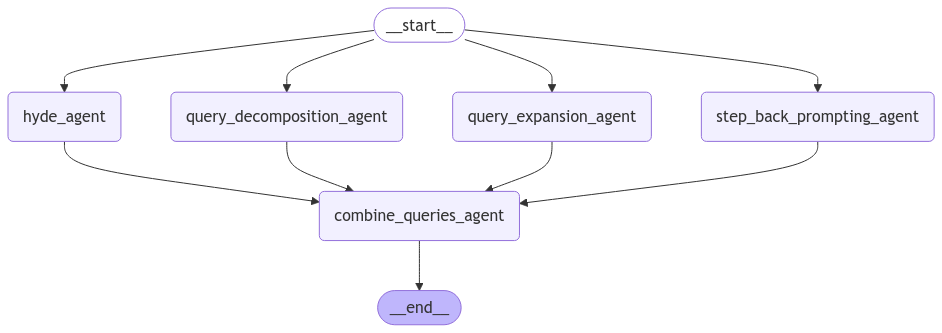

In [13]:
def display_graph(graph):
    display(Image(graph.get_graph().draw_mermaid_png()))

display_graph(graph)

The user now asks the question: `What is the population of the capital city of the country where Bastille Prison is located?`

In [ ]:
user_inp = input("User: ")
async for chunk in graph.astream({"query": user_inp}):
    final_chunk = chunk

In [39]:
final_chunk["combine_queries_agent"]["messages"]

[['What is the capital of the country where Bastille Prison is located?',
  'What is the population of that capital city?'],
 ['What is the population of the capital city of the country where Bastille Prison is situated?',
  'What is the number of people living in the capital of the country where Bastille Prison can be found?',
  'How many inhabitants are there in the capital of the country where Bastille Prison is located?'],
 'What is the population of the capital of the country where Bastille Prison is located? What is the population of the capital of the country where Bastille Prison is located? What is the population of the capital of the country where Bastille Prison is located?The Bastille Prison, a symbol of royal authority in the center of Paris, was famously stormed during the French Revolution on July 14, 1789. Paris, the capital city of France, is renowned not only for its historical significance but also for its vibrant culture, art, and fashion. As of the latest estimates